# CryoDRGN interactive filtering

This jupyter notebook provides multiple methods for filtering particles based on the latent space, including:
* clustering of the latent space (k-means or Gaussian mixture model)
* outlier detection (Z-score)
* interactive selection with a lasso tool

For each method, the selected particles are tracked in the variable, `ind_selected`.

Once the selection has been finalized, the selected particles are saved as a `index.pkl` file at the end of this notebook. The selected indices can be provided to cryoDRGN with the `--ind` argument to train a new model on a subset of the images or converted to `.star` file format.

For more information, see the tutorial on [Notion page].

In [1]:
import pandas as pd
import numpy as np
import pickle
import subprocess
import os, sys

from cryodrgn import analysis
from cryodrgn import utils
from cryodrgn import dataset
from cryodrgn import ctf
                
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from ipywidgets import interact, interactive, HBox, VBox
from scipy.spatial.transform import Rotation as RR
py.init_notebook_mode()
from IPython.display import FileLink, FileLinks

In [2]:
# Enable interactive widgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


### Load results

In [3]:
# Specify the workdir and the epoch number (0-based index) to analyze
WORKDIR = '..' 
EPOCH = 39 # CHANGE ME

In [4]:
print(os.path.abspath(WORKDIR))

/work/jpma/luo/tomo/warp_DEF/metadata/optomo/zribotmt


In [5]:
# Load z
latents = utils.load_torch_pkl(f'{WORKDIR}/z.{EPOCH}.pkl')
# load composition latent code
z = latents["mu"]
# load conformation latent code
multi_z = latents["multi_mu"]

In [6]:
# Load UMAP
umap = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/umap.pkl')
# or run UMAP
# umap = analysis.run_umap(z)

In [7]:
# Load kmeans
K = 20
kmeans_labels = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/labels.pkl')
kmeans_centers = np.loadtxt(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/centers.txt')
#kmeans_centers = np.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/centers.pkl')
#kmeans_centers_ind = np.loadtxt(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/centers_ind.txt', dtype=np.int64)
# Or re-run kmeans with the desired number of classes
#kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, 20)

# Get index for on-data cluster center
kmeans_centers, centers_ind = analysis.get_nearest_point(z, kmeans_centers)

### Define helper functions

In [8]:
def invert_selection(ind_selected):
    return np.array(sorted(set(np.arange(len(z))) - set(ind_selected)))

In [9]:
def combine_selection(ind_sel1, ind_sel2, kind='union'):
    assert kind in ('union','intersection')
    return analysis.combine_ind(len(z), ind_sel1, ind_sel2, kind)

In [10]:
def select_clusters(labels, cluster_ids):
    return analysis.get_ind_for_cluster(labels, cluster_ids)

### Load dataset

In [11]:
# Load configuration file
config = utils.load_pkl(f'{WORKDIR}/config.pkl')
print(config)

{'dataset_args': {'particles': '/work/jpma/luo/tomo/warp_DEF/metadata/optomo/zribotmt/ribotm.star', 'norm': [0, 0.99977463], 'invert_data': True, 'ind': None, 'keepreal': False, 'window': True, 'window_r': 0.85, 'datadir': '/work/jpma/luo/tomo/warp_DEF/metadata/warp_tiltseries', 'ctf': None, 'poses': '/work/jpma/luo/tomo/warp_DEF/metadata/optomo/zribotmt/ribotm_pose_euler.pkl', 'do_pose_sgd': False, 'real_data': True, 'downfrac': 1.0}, 'lattice_args': {'D': 129, 'extent': 0.5, 'ignore_DC': True}, 'model_args': {'qlayers': 3, 'qdim': 256, 'players': 3, 'pdim': 256, 'zdim': 12, 'encode_mode': 'grad', 'enc_mask': 64, 'pe_type': 'vanilla', 'pe_dim': None, 'domain': 'fourier', 'activation': 'relu', 'template_type': 'conv', 'down_vol_size': 114, 'Apix': 3.37, 'templateres': 128}, 'seed': 6776}


In [12]:
# Load poses
pose_pkl = config['dataset_args']['poses']
# you can also load {WORKDIR}/pose.{EPOCH}.pkl
rot, trans, euler = utils.load_pkl(pose_pkl)

In [13]:
# Convert rotation matrices to euler angles
#euler = RR.from_matrix(rot).as_euler('zyz', degrees=True)

In [14]:
# define the original starfile 
starfile_orig = config['dataset_args']['particles']
from cryodrgn import starfile
starfile_orig = starfile.Starfile.load(starfile_orig)

In [15]:
# Load input particles, change tilt_step, tilt_range according to your data
particles, ctfs, ctf_files, warp_ctf = dataset.load_warp_subtomos(config['dataset_args']['particles'],
                            lazy=True,
                            datadir=config['dataset_args']['datadir'],
                            tilt_step=2, tilt_range=50,)
N_orig = len(particles)
print(f"loaded {N_orig} particles")

loaded 50000 particles


### View pose distribution

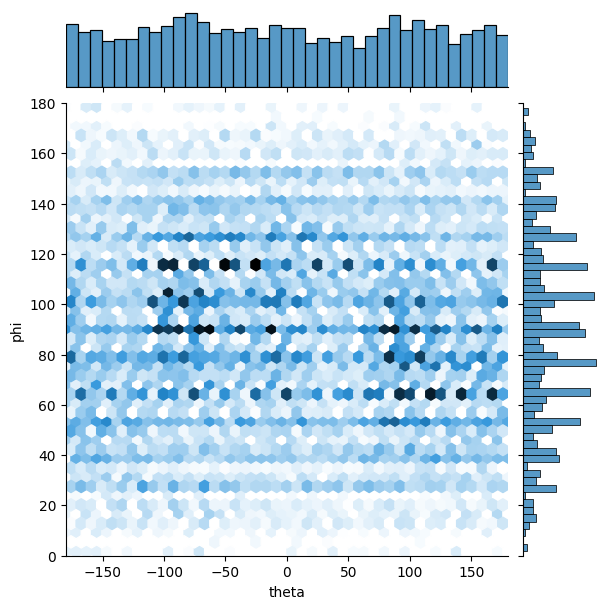

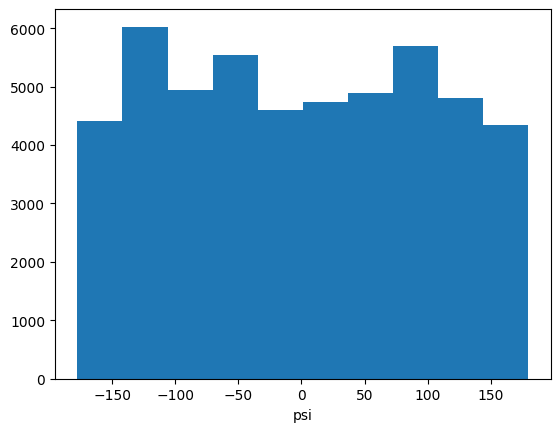

In [16]:
# rotations
analysis.plot_euler(euler[:,0],euler[:,1], euler[:,2])

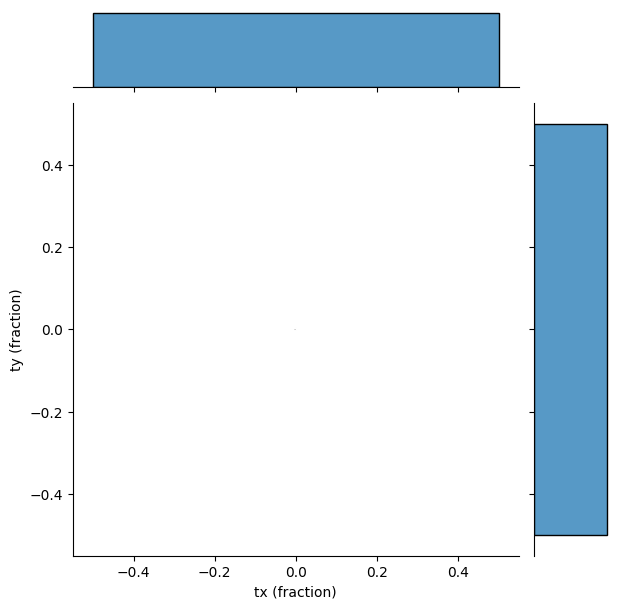

In [17]:
# translations
sns.jointplot(x=trans[:,0],
              y=trans[:,1],
              kind='hex').set_axis_labels('tx (fraction)','ty (fraction)')

### Learning curve

### PCA

In [16]:
pc, pca = analysis.run_pca(z)

2026-02-23 15:41:04     Explained variance ratio:
2026-02-23 15:41:04     [0.19316461 0.1133576  0.09055165 0.08916906 0.08231673 0.07544862
 0.07107299 0.06823767 0.0629412  0.05860259 0.05169187 0.04344541]


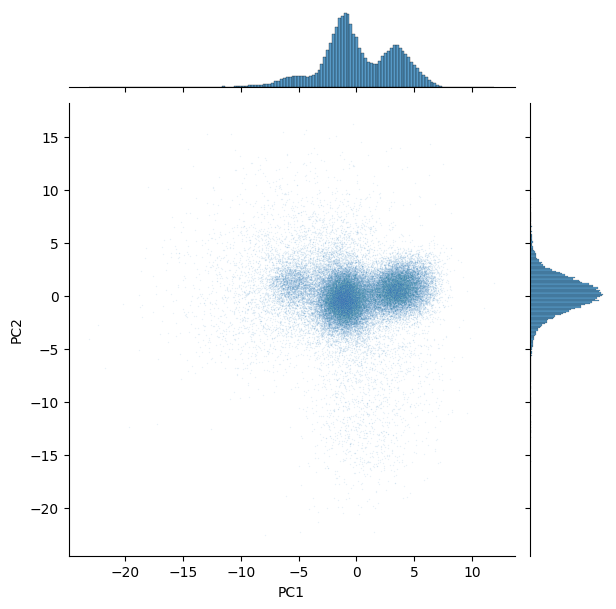

In [17]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], alpha=.1, s=1)
g.set_axis_labels('PC1', 'PC2')

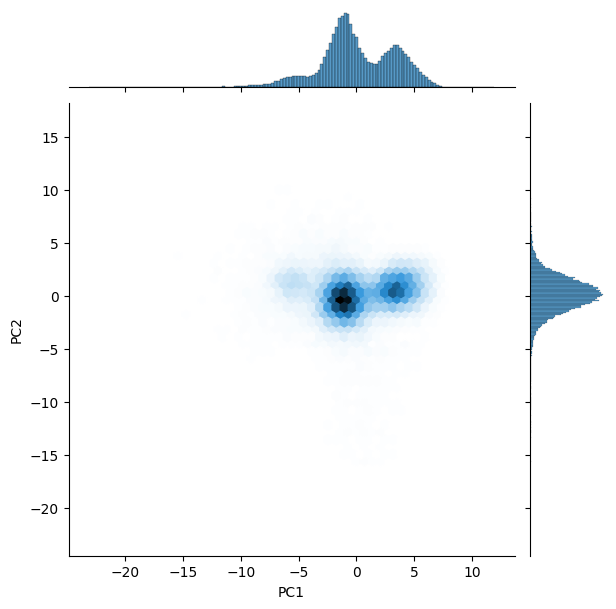

In [18]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], kind='hex')
g.set_axis_labels('PC1', 'PC2')

Text(0, 0.5, 'explained variance')

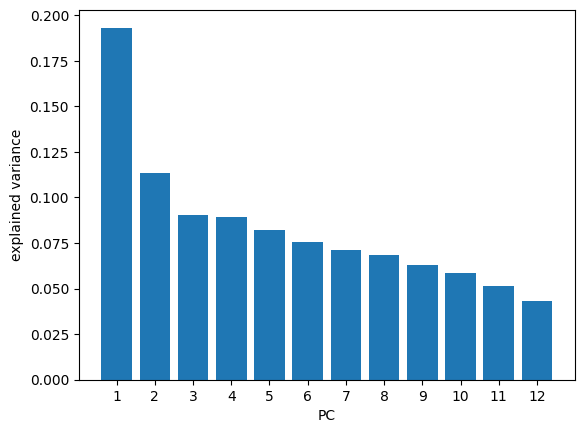

In [19]:
plt.bar(np.arange(z.shape[1])+1,pca.explained_variance_ratio_)
plt.xticks(np.arange(z.shape[1])+1)
plt.xlabel('PC')
plt.ylabel('explained variance')

### UMAP

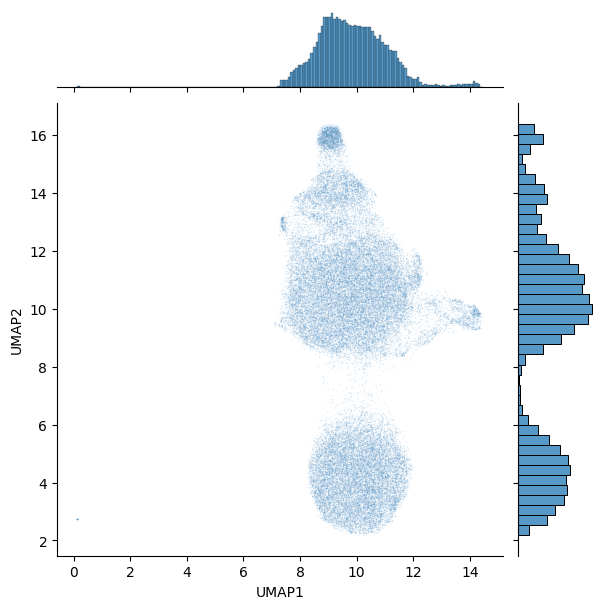

In [20]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], alpha=.1, s=1)
g.set_axis_labels('UMAP1', 'UMAP2')

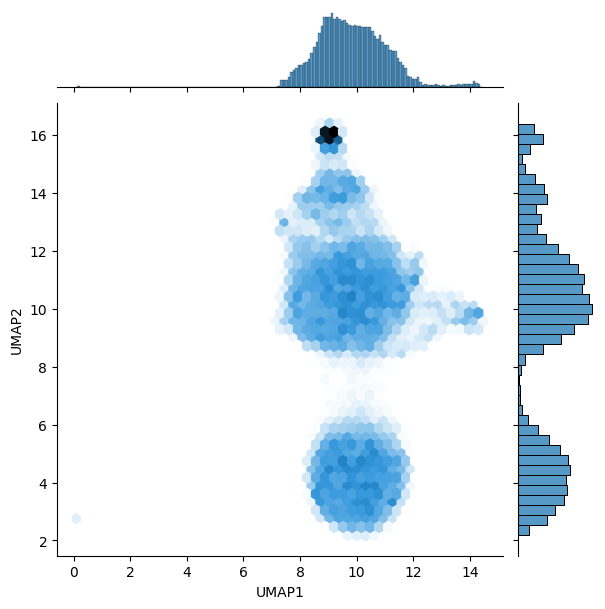

In [21]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], kind='hex')
g.set_axis_labels('UMAP1', 'UMAP2')

# Filter by clustering

Select particles based on k-means cluster labels or GMM cluster labels

### View K-means clusters

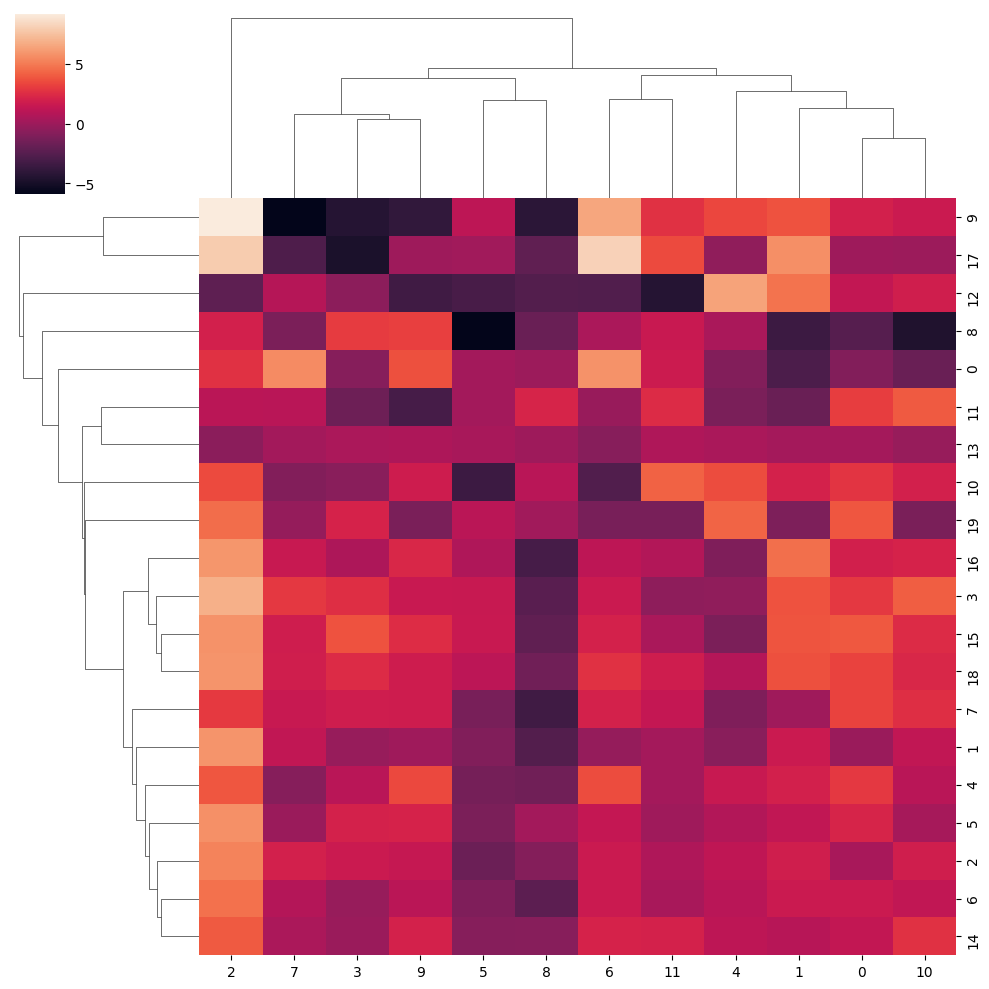

In [22]:
# Optionally, re-run kmeans with the desired number of classes
K = 20
kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, K)
# Get index for on-data cluster center
kmeans_centers, centers_ind = analysis.get_nearest_point(z, kmeans_centers)

Text(0, 0.5, 'PC2')

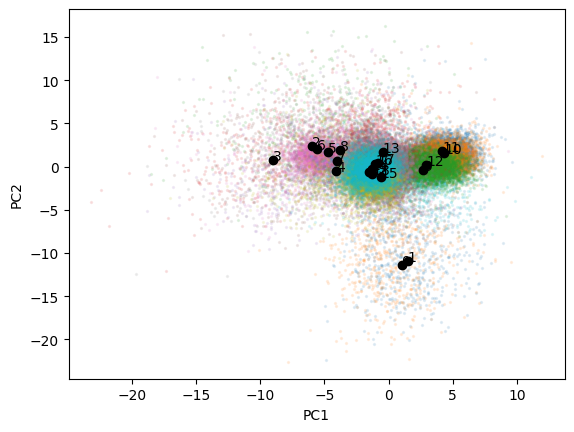

In [23]:
K = len(set(kmeans_labels))
c = pca.transform(kmeans_centers) # transform to view with PCs
analysis.plot_by_cluster(pc[:,0], pc[:,1], K, 
                         kmeans_labels, 
                         centers=c,
                         annotate=True)
plt.xlabel('PC1')
plt.ylabel('PC2')

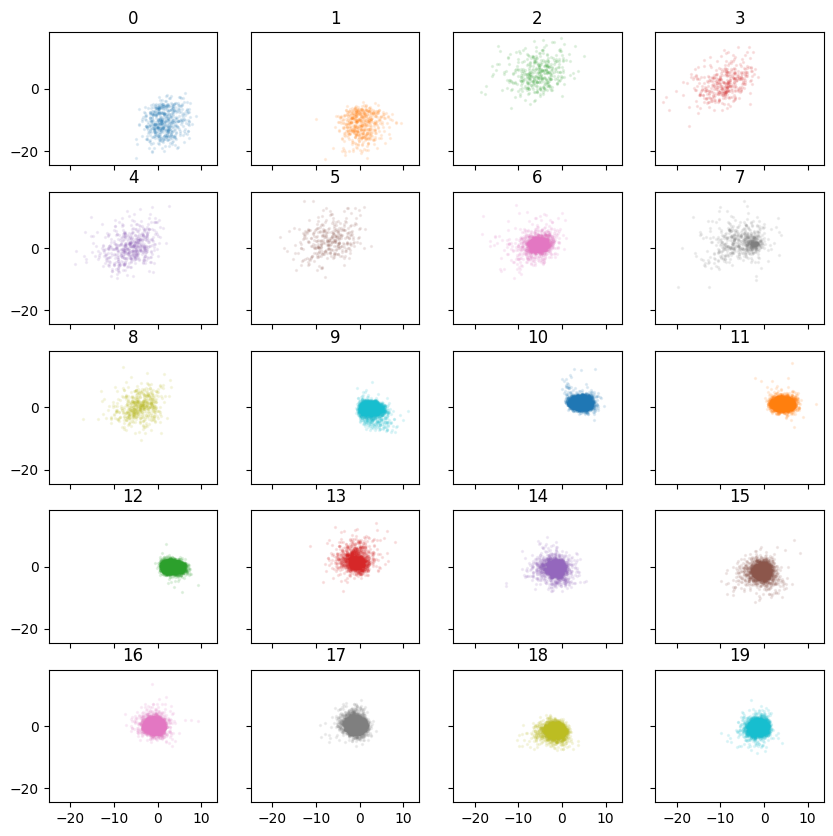

In [24]:
fig, ax = analysis.plot_by_cluster_subplot(pc[:,0], pc[:,1], K, 
                            kmeans_labels)

Text(0, 0.5, 'UMAP2')

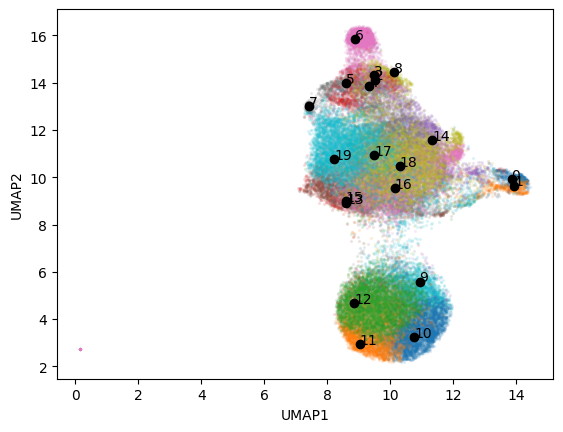

In [25]:
analysis.plot_by_cluster(umap[:,0], umap[:,1], K, 
                         kmeans_labels, 
                         centers_ind=centers_ind,
                         annotate=True)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

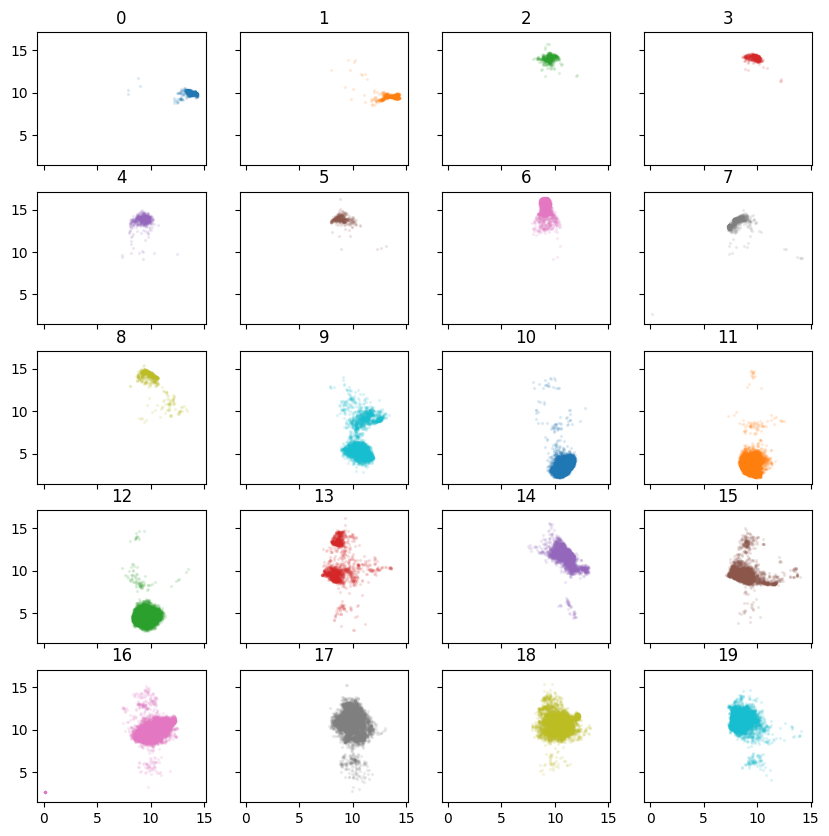

In [26]:
fig, ax = analysis.plot_by_cluster_subplot(umap[:,0], umap[:,1], K, 
                            kmeans_labels)

**Select particles based on k-means clustering**

In [27]:
cluster_ids = [9,10,11,12] # set clusters to select, 0 and 2 in this example
ind_selected = select_clusters(kmeans_labels, cluster_ids)
ind_selected_not = invert_selection(ind_selected)
print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

Selected indices:
[    1     2     4 ... 49796 49836 49876]
Number of selected points:
17445
Number of unselected points:
32555


In [28]:
#save selected ind to starfile
outstar = f"{WORKDIR}/analyze.{EPOCH}/cluster_sel.star"
print(f"write selection to {outstar}")
starfile_orig.write_ind(outstar, ind_selected)

write selection to ../analyze.39/cluster_sel.star


Text(0, 0.5, 'PC2 (0.11)')

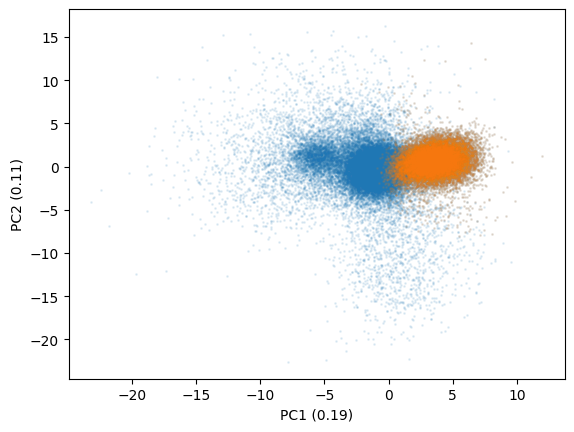

In [29]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

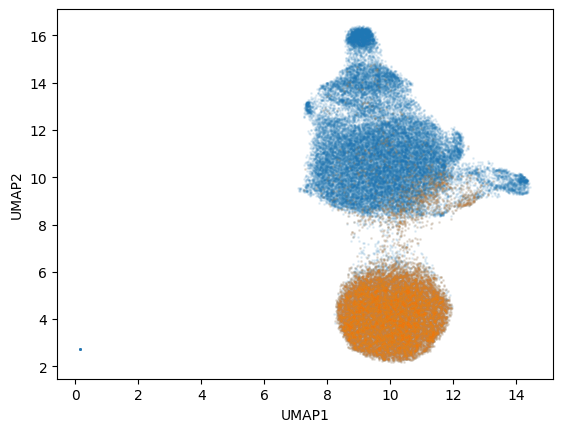

In [30]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

### GMM-clustering

In [33]:
G = 3 # or change to desired cluster number
random_state = np.random.randint(100000) # sample random integer
print(f'Random state: {random_state}')
gmm_labels, gmm_centers = analysis.cluster_gmm(z, G, random_state=random_state)
gmm_centers, gmm_centers_ind = analysis.get_nearest_point(z, gmm_centers)

Random state: 2994


Text(0, 0.5, 'PC2')

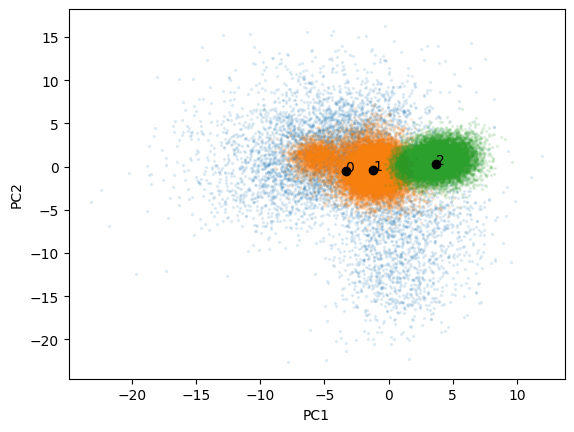

In [34]:
analysis.plot_by_cluster(pc[:,0], pc[:,1], G, 
                         gmm_labels, 
                         centers_ind=gmm_centers_ind,
                         annotate=True)
plt.xlabel('PC1')
plt.ylabel('PC2')

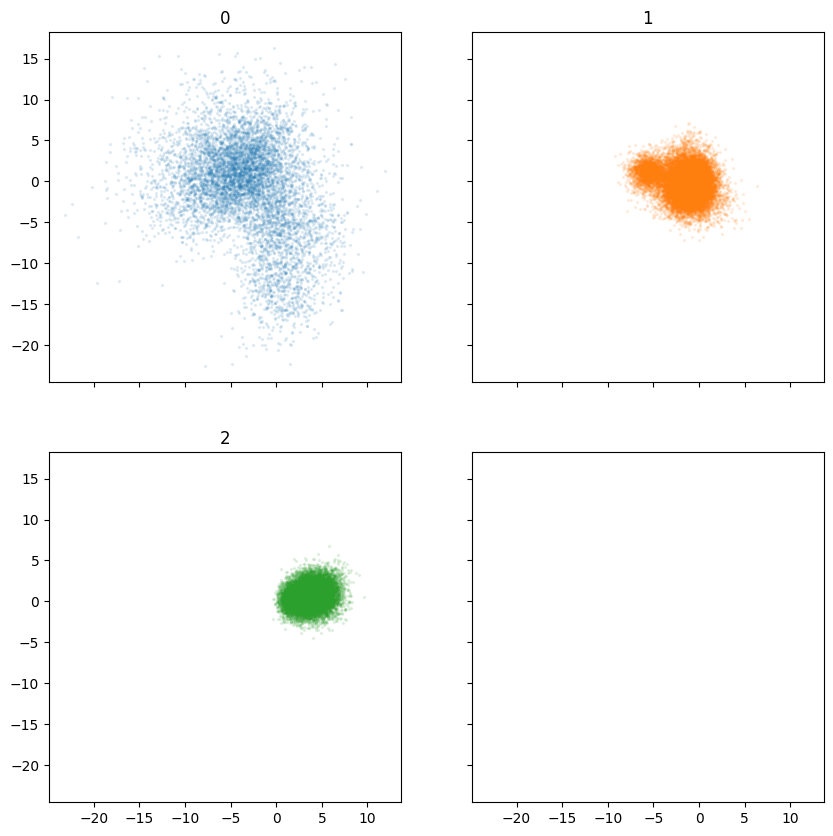

In [35]:
fig, ax = analysis.plot_by_cluster_subplot(pc[:,0], pc[:,1], G, gmm_labels)

Text(0, 0.5, 'UMAP2')

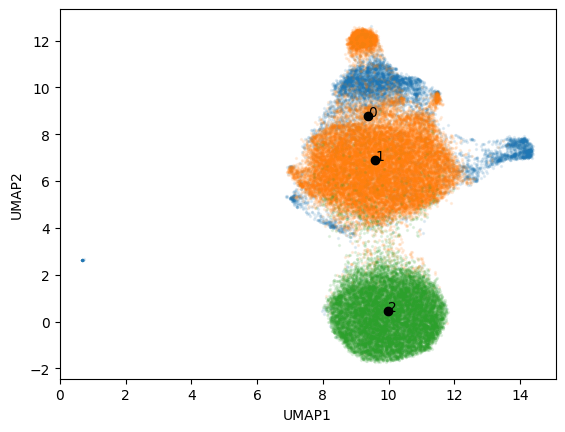

In [36]:
analysis.plot_by_cluster(umap[:,0], umap[:,1], G, 
                         gmm_labels, 
                         centers_ind=gmm_centers_ind,
                         annotate=True)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

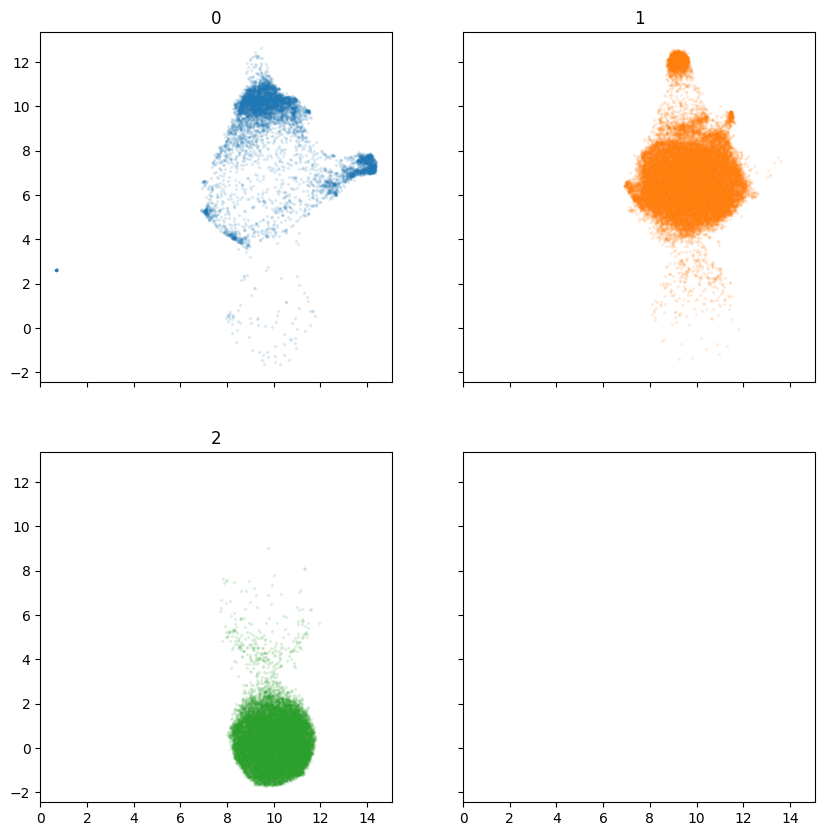

In [37]:
fig, ax = analysis.plot_by_cluster_subplot(umap[:,0], umap[:,1], G, gmm_labels)

**Select particles based on GMM-means clustering**

In [38]:
cluster_ids = [2] # set clusters to select, 2 in this example
ind_selected = select_clusters(gmm_labels, cluster_ids)
ind_selected_not = invert_selection(ind_selected)
print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

Selected indices:
[   53    66   101 ... 49796 49836 49876]
Number of selected points:
16687
Number of unselected points:
33313


Text(0, 0.5, 'PC2 (0.11)')

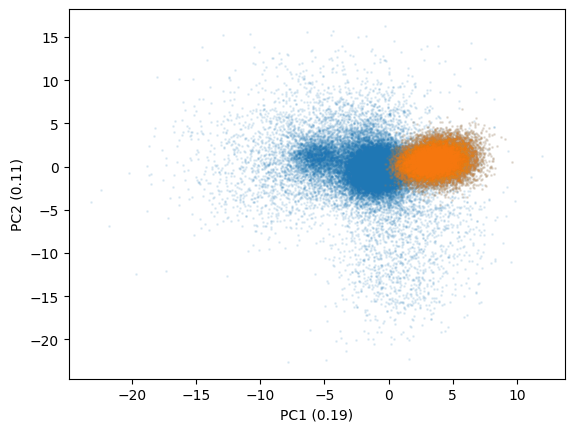

In [39]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

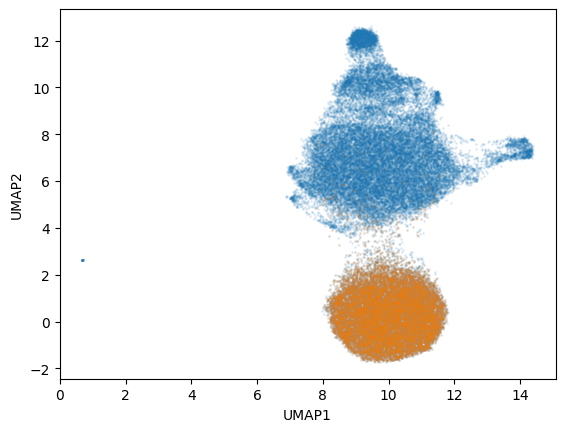

In [40]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Filter outlier particles

In [41]:
# Compute magnitude of latent encodings
znorm = np.sum(z.cpu().numpy()**2,axis=1)**.5

/tmp/ipykernel_273155/3443149376.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 0, '||z||')

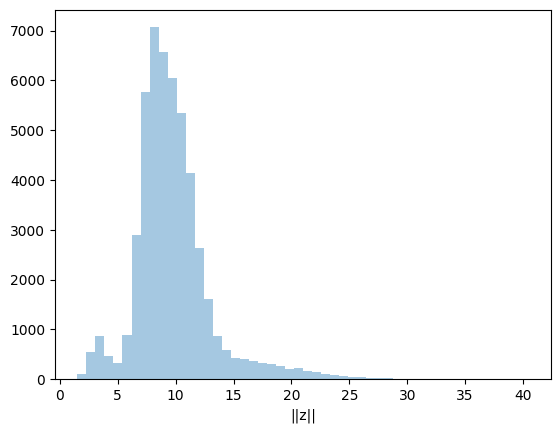

In [42]:
# Distribution of ||z||
sns.distplot(znorm, kde=False)
plt.xlabel('||z||')

In [43]:
# By default, identify particles with ||z|| 2 std deviations above mean
zscore = 2
thresh = znorm.mean()+zscore*znorm.std()
print(f'Mean: {znorm.mean()}, Std: {znorm.std()}, Selected threshold: {thresh}')

Mean: 9.732065200805664, Std: 3.359097957611084, Selected threshold: 16.450261116027832


In [44]:
ind_outliers = np.where(znorm >= thresh)[0]
ind_outliers_not = invert_selection(ind_outliers)

print('Selected indices:')
print(ind_outliers)
print('Number of selected points:')
print(len(ind_outliers))
print('Number of unselected points:')
print(len(ind_outliers_not))

Selected indices:
[    0     1     2 ... 49478 49612 49717]
Number of selected points:
2363
Number of unselected points:
47637


/tmp/ipykernel_273155/1172413290.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 1.0, 'Magnitude of particle latent encodings')

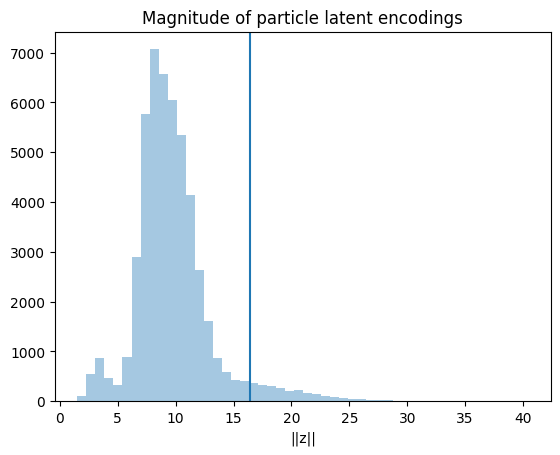

In [45]:
g = sns.distplot(znorm, kde=False)
plt.axvline(x=thresh)
plt.xlabel('||z||')
plt.title('Magnitude of particle latent encodings')

Text(0.5, 1.0, 'Particles with ||z|| > 16.450261116027832')

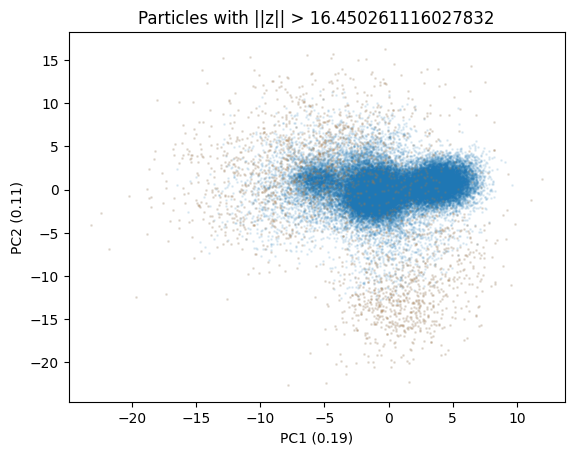

In [46]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_outliers,0], pc[ind_outliers,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))
plt.title(f'Particles with ||z|| > {thresh}')

Text(0.5, 1.0, 'Particles with ||z|| > 16.450261116027832')

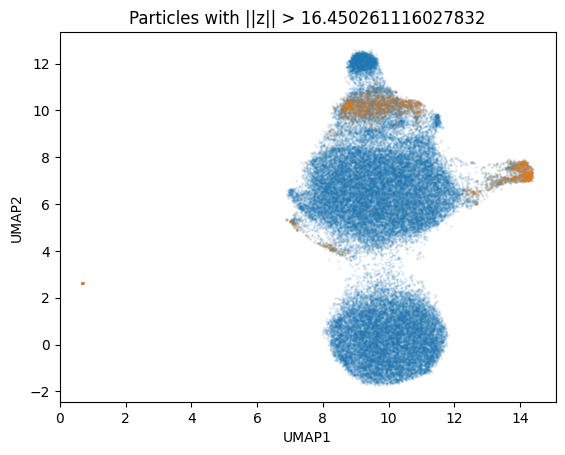

In [47]:
# View UMAP
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_outliers,0], umap[ind_outliers,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title(f'Particles with ||z|| > {thresh}')

In [48]:
# Assign variables for viz/saving cells at the end of the notebook
ind_selected = ind_outliers
ind_selected_not = ind_outliers_not

# Interactive visualization

Interactive visualization of the latent encodings for the trained model. Each point represents a particle image of the dataset. The hover text includes the index of the image in the particle stack. 

In [49]:
# Load data into a pandas dataframe
df = analysis.load_dataframe(z=z, 
                             pc=pc, 
                             euler=euler, 
                             trans=trans, 
                             labels=kmeans_labels, 
                             umap=umap,
                             znorm=znorm)
df.head()

UMAP1     UMAP2       PC1       PC2       PC3       PC4       PC5  \
0  8.748081  3.894274  6.656941 -7.842309  1.535523  0.255042 -0.607652   
1  9.700991  4.149312  5.392535 -3.641682 -1.084506  1.191634 -0.182632   
2  8.383261  4.092886  6.224563 -4.971280  3.470906 -3.847166  2.713737   
3  9.962504  4.133681  4.189430 -4.721551 -1.716697  3.109924  0.395499   
4  8.582594  3.968547  6.089789 -5.440532 -0.903240  0.821584  1.891738   

        PC6       PC7       PC8  ...        z4        z5        z6        z7  \
0  1.194171  1.889084 -4.397065  ... -0.518764 -1.674347  6.970375 -5.732965   
1 -1.618405  0.584754 -8.192908  ... -3.319044 -4.101903  6.279761 -0.760100   
2 -2.931728 -0.361915 -3.168117  ... -4.898807  0.296424  3.210183 -4.509254   
3  0.012765  5.257620 -7.605785  ... -2.198974 -6.777686  8.854194 -0.703041   
4 -4.061272  2.001981 -4.415947  ... -4.602042 -2.068997  6.880310 -1.618076   

         z8        z9       z10       z11      znorm  index  
0 -4.826254  4.625417  4.872367  0.586998  17.383762      0  
1 -1.706206  4.640049  4.091875 -2.014920  16.514454      1  
2 -1.214798  4.744016  4.674080  5.404395  16.624632      2  
3 -3.097317  4.725839  5.711753 -2.346907  17.126894      3  
4 -2.575923  6.711619  2.870449  0.890214  16.342495      4  

[5 rows x 34 columns]

### Interactive selection

The next two cells contain helper code to select particles using an interactive lasso tool. 

1. In the first cell, select points with the lasso tool. The table widget is dynamically updated with the most recent selection's indices. 
2. Then once you've finalized your selection, **run the next cell** to save the particle indices for downstream analysis/viz.

(Double click to clear selection)

In [50]:
import anywidget, ipywidgets
print(anywidget.__version__)
print(ipywidgets.__version__)
import anywidget

class W(anywidget.AnyWidget):
    _esm = "export function render({model, el}) { el.innerText = 'anywidget ok'; }"

W()

0.9.21
8.1.8


In [51]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df)
VBox((widget,fig,ind_table))

In [53]:
ind_selected = ind_table.data[0].cells.values[0] # save table values
ind_selected = np.array(ind_selected)
ind_selected_not = invert_selection(ind_selected)

print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

Selected indices:
[   53    66   101 ... 49796 49836 49876]
Number of selected points:
16767
Number of unselected points:
33233


Text(0, 0.5, 'PC2 (0.11)')

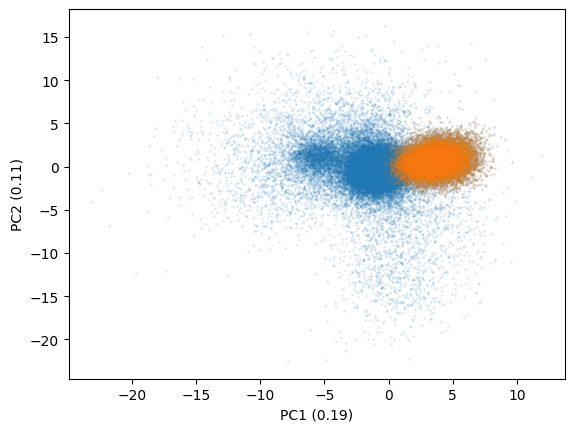

In [54]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

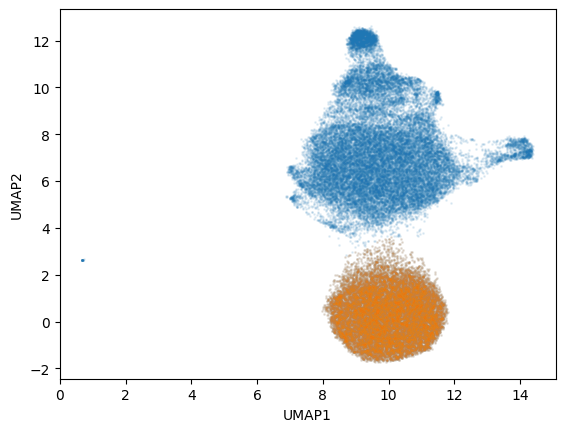

In [55]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# View particles

View images from selected particles

In [29]:
particle_ind = ind_selected # or set to custom selection

In [57]:
# Choose 9 particles to view at random
if len(particle_ind) > 9:
    ind_subset9 = np.random.choice(particle_ind, 9, replace=False)
else: 
    ind_subset9 = particle_ind
print(ind_subset9)

[16203 48801   542  4301  6432 27449 32934 23316  8903]


In [70]:
def circular_mask(shape, radius=None, center=None):
    H, W = shape
    if center is None:
        center = (H//2, W//2)
    if radius is None:
        radius = min(H, W) // 2

    Y, X = np.ogrid[:H, :W]
    dist2 = (Y-center[0])**2 + (X-center[1])**2
    return dist2 <= radius**2

Text(0, 0.5, 'UMAP2')

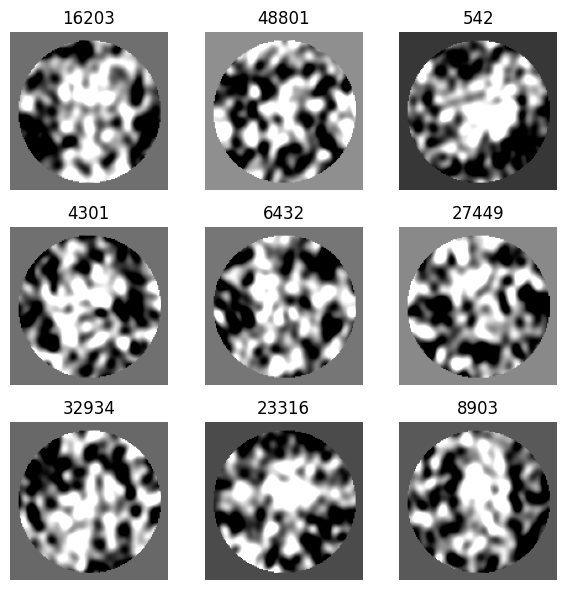

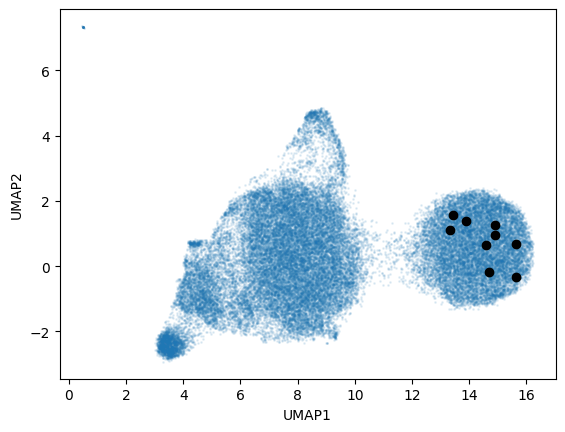

In [73]:
#visualize selection
from scipy.ndimage import gaussian_filter

sigma = 3.5

p = [particles[ii].get().sum(axis=0) for ii in ind_subset9] # z axis projection
p = [gaussian_filter(x, sigma=sigma) for x in p] #gaussian blurring
mask = circular_mask(p[0].shape, radius=p[0].shape[0]//2*0.9) #circular mask
p = [x*mask for x in p]
#_ = analysis.plot_projections(p, ind_subset9)
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for ax, img, ind in zip(axes.flat, p, ind_subset9):   # p = list of 9 images
    vmin, vmax = np.percentile(img, (10, 90))
    ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(ind)

plt.tight_layout()
plt.figure()
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_subset9,0], umap[ind_subset9,1], color='k')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Save selection

Save the particle indices for the selected (`ind_selected`) and unselected particles (`ind_selected_not`) as a .pkl file for downstream processing in cryoDRGN or with other tools.

Rename the paths as desired. Note that the indices will be automatically converted if the current cryoDRGN training run has already been filtered (`ind_orig` loaded in an earlier cell).

In [47]:
# Set selection as either the kept or bad particles (for file naming purposes)
ind_keep = ind_selected # or ind_selected_not
ind_bad = ind_selected_not # or ind_selected

Text(0, 0.5, 'PC2 (0.11)')

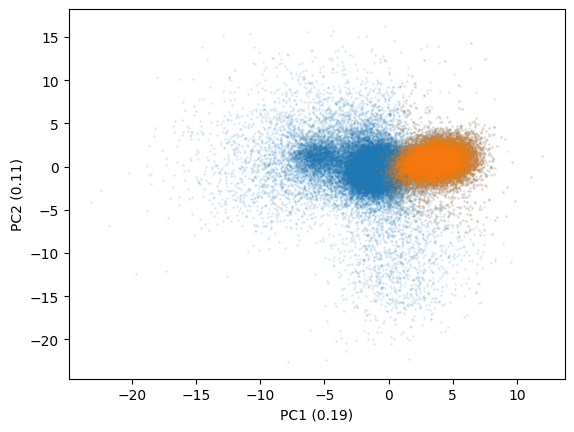

In [48]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_keep,0], pc[ind_keep,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

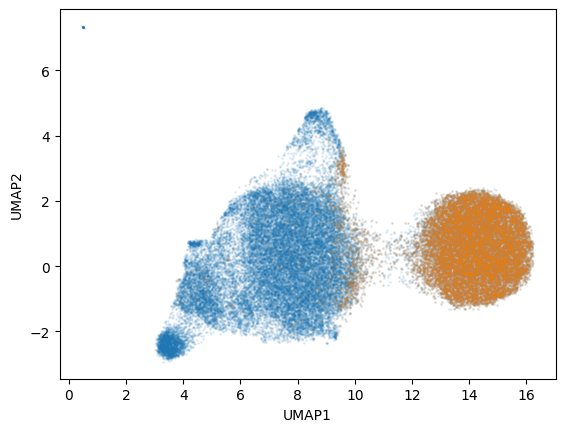

In [49]:
# View UMAP
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_keep,0], umap[ind_keep,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [50]:
print('Kept particle indices:')
print(ind_keep)
print('Number of kept particles:')
print(len(ind_keep))
print('Number of bad particles:')
print(len(ind_bad))

Kept particle indices:
[    1     2     4 ... 49796 49836 49876]
Number of kept particles:
17418
Number of bad particles:
32582


## Visualize tomogram

Load a tomogram (`.mrc`) and inspect central orthogonal slices. If the file exists, an interactive slider is created to browse Z slices.


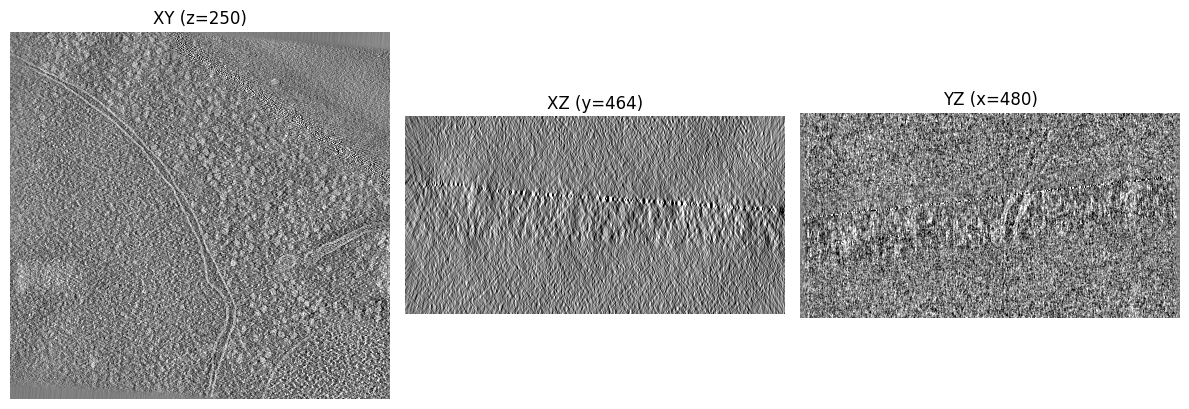

interactive(children=(IntSlider(value=245, description='z', max=499, step=5), Output()), _dom_classes=('widget…

In [32]:
from cryodrgn import mrc

# Path to a tomogram volume (.mrc)
TOMOGRAM_MRC = '../../../warp_tiltseries/reconstruction_bak/TS_027_13.48Apx.mrc'  # CHANGE ME
# Tighter clipping gives stronger contrast.
CONTRAST_PERCENTILES = (5, 95)

def show_tomogram_slices(tomo_path, z=None, cmap='gray', contrast_percentiles=(5, 95)):
    tomo, _ = mrc.parse_mrc(tomo_path, lazy=False)
    tomo = np.asarray(tomo)
    assert tomo.ndim == 3, f'Expected a 3D tomogram, got shape {tomo.shape}'

    vmin, vmax = np.percentile(tomo, list(contrast_percentiles))
    nz, ny, nx = tomo.shape
    if z is None:
        z = nz // 2
    z = int(np.clip(z, 0, nz - 1))
    y = ny // 2
    x = nx // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(tomo[z, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title(f'XY (z={z})')
    axes[1].imshow(tomo[:, y, :], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title(f'XZ (y={y})')
    axes[2].imshow(tomo[:, :, x], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[2].set_title(f'YZ (x={x})')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    return tomo

if os.path.exists(TOMOGRAM_MRC):
    tomo = show_tomogram_slices(TOMOGRAM_MRC, contrast_percentiles=CONTRAST_PERCENTILES)
    step = max(1, tomo.shape[0] // 100)
    _ = interact(
        lambda z: show_tomogram_slices(TOMOGRAM_MRC, z=z, contrast_percentiles=CONTRAST_PERCENTILES),
        z=(0, tomo.shape[0] - 1, step)
    )
else:
    print('Set TOMOGRAM_MRC to a valid .mrc file path to enable visualization.')


## Coordinates for selected particles in one tomogram

Extract coordinates from the input STAR table for the current selected particles (`ind_keep` or `ind_selected`), then filter to a specific tomogram.


Found 10 tomogram ids in current selection using column _rlnMicrographName:
['TS_026.tomostar', 'TS_027.tomostar', 'TS_028.tomostar', 'TS_029.tomostar', 'TS_030.tomostar', 'TS_034.tomostar', 'TS_037.tomostar', 'TS_041.tomostar', 'TS_043.tomostar', 'TS_045.tomostar']
Using tomogram filter: TS_027.tomostar
Number of selected particles in this tomogram: 1116


particle_index _rlnMicrographName  _rlnCoordinateX  _rlnCoordinateY  \
4001            4001    TS_027.tomostar           2452.0           1584.0   
4004            4004    TS_027.tomostar           1048.0            808.0   
4005            4005    TS_027.tomostar           1068.0            800.0   
4006            4006    TS_027.tomostar            496.0           2016.0   
4011            4011    TS_027.tomostar           1976.0           3364.0   
4014            4014    TS_027.tomostar           3448.0           1452.0   
4015            4015    TS_027.tomostar           1772.0           1072.0   
4018            4018    TS_027.tomostar           2664.0            504.0   
4022            4022    TS_027.tomostar           3612.0           2108.0   
4023            4023    TS_027.tomostar           3472.0           2176.0   
4024            4024    TS_027.tomostar           2668.0            580.0   
4027            4027    TS_027.tomostar            956.0            780.0   
4029            4029    TS_027.tomostar           3712.0           2888.0   
4030            4030    TS_027.tomostar           2880.0            624.0   
4033            4033    TS_027.tomostar           2020.0           1472.0   
4036            4036    TS_027.tomostar           1616.0           1128.0   
4039            4039    TS_027.tomostar           3636.0           2688.0   
4041            4041    TS_027.tomostar           2120.0            408.0   
4042            4042    TS_027.tomostar            136.0           1480.0   
4043            4043    TS_027.tomostar           3204.0           2484.0   

      _rlnCoordinateZ  
4001            784.0  
4004            700.0  
4005            752.0  
4006            592.0  
4011            584.0  
4014            912.0  
4015            824.0  
4018            956.0  
4022            848.0  
4023            812.0  
4024           1264.0  
4027            768.0  
4029           1012.0  
4030           1516.0  
4033           1004.0  
4036            808.0  
4039           1152.0  
4041           1520.0  
4042            616.0  
4043            956.0

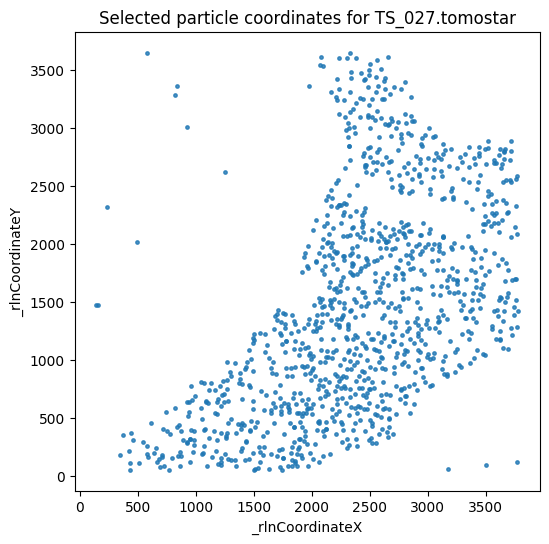

In [33]:
# Uses starfile_orig (loaded above) and current selection (ind_keep or ind_selected)
# Set this to a tomogram identifier string found in the printed list below.
SELECTED_TOMOGRAM = 'TS_027.tomostar'  # e.g. 'TS_001.tomostar'
SAVE_COORDS_CSV = False

if 'ind_keep' in globals():
    selected_idx = np.asarray(ind_keep, dtype=int)
else:
    selected_idx = np.asarray(ind_selected, dtype=int)

df_star = starfile_orig.df.reset_index(drop=True).copy()
df_sel = df_star.iloc[selected_idx].copy()
df_sel['particle_index'] = selected_idx

coord_candidates = [
    ['_rlnCoordinateX', '_rlnCoordinateY', '_rlnCoordinateZ'],
    ['_rlnCoordinateX', '_rlnCoordinateY'],
    ['_rlnCenteredCoordinateXAngst', '_rlnCenteredCoordinateYAngst', '_rlnCenteredCoordinateZAngst'],
    ['_rlnCenteredCoordinateXAngst', '_rlnCenteredCoordinateYAngst'],
    ['_wrpCoordinateX', '_wrpCoordinateY', '_wrpCoordinateZ'],
    ['_wrpCoordinateX', '_wrpCoordinateY']
]
coord_cols = None
for cols in coord_candidates:
    if all(c in df_sel.columns for c in cols):
        coord_cols = cols
        break

if coord_cols is None:
    coord_cols = [c for c in df_sel.columns if 'Coordinate' in c]

if len(coord_cols) == 0:
    raise ValueError('No coordinate columns found in STAR file headers.')

tomo_candidates = ['_rlnTomoName', '_rlnMicrographName', '_rlnGroupName', '_rlnImageName']
tomo_col = next((c for c in tomo_candidates if c in df_sel.columns), None)
if tomo_col is None:
    raise ValueError('No tomogram identifier column found. Tried: ' + ', '.join(tomo_candidates))

tomo_values = sorted(df_sel[tomo_col].astype(str).unique())
print(f'Found {len(tomo_values)} tomogram ids in current selection using column {tomo_col}:')
print(tomo_values[:20])
if len(tomo_values) > 20:
    print('... (truncated)')

if SELECTED_TOMOGRAM is None:
    selected_tomo_value = tomo_values[0]
else:
    selected_tomo_value = str(SELECTED_TOMOGRAM)

mask = df_sel[tomo_col].astype(str).str.contains(selected_tomo_value, regex=False)
coords_selected_tomo = df_sel.loc[mask, ['particle_index', tomo_col] + coord_cols].copy()

for c in coord_cols:
    coords_selected_tomo[c] = pd.to_numeric(coords_selected_tomo[c], errors='coerce')

print(f'Using tomogram filter: {selected_tomo_value}')
print(f'Number of selected particles in this tomogram: {len(coords_selected_tomo)}')
display(coords_selected_tomo.head(20))

if len(coord_cols) >= 2 and len(coords_selected_tomo) > 0:
    plt.figure(figsize=(6, 6))
    plt.scatter(coords_selected_tomo[coord_cols[0]], coords_selected_tomo[coord_cols[1]], s=6, alpha=0.8)
    plt.xlabel(coord_cols[0])
    plt.ylabel(coord_cols[1])
    plt.title(f'Selected particle coordinates for {selected_tomo_value}')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

if SAVE_COORDS_CSV:
    safe_name = str(selected_tomo_value).replace('/', '_').replace(' ', '_')
    out_csv = f'{WORKDIR}/analyze.{EPOCH}/selected_coords_{safe_name}.csv'
    coords_selected_tomo.to_csv(out_csv, index=False)
    print(f'Saved: {out_csv}')


## Overlay selected particles on a tomogram

Display selected particles as circles on tomogram slices. Use `COORD_SCALE_FACTOR_XY` (and optionally `COORD_SCALE_FACTOR_Z`) to convert STAR coordinates to tomogram voxel coordinates.


In [37]:
from matplotlib.patches import Circle

# If TOMOGRAM_MRC is already set above, this reuses it.
TOMOGRAM_OVERLAY_MRC = TOMOGRAM_MRC if 'TOMOGRAM_MRC' in globals() else '/path/to/tomogram.mrc'

# Scale factors to convert STAR coordinates -> tomogram voxel coordinates.
# Example: if STAR coords are in unbinned and tomogram is 4 times binned, use 0.25.
COORD_SCALE_FACTOR_XY = 0.25
COORD_SCALE_FACTOR_Z = 0.25

MARKER_RADIUS_PX = 12
SLICE_HALF_WIDTH = 2  # +/- z window for showing points near current slice
CIRCLE_COLOR = 'lime'
CIRCLE_LINEWIDTH = 1.2

if 'coords_selected_tomo' not in globals():
    raise ValueError('Run the previous coordinates section first to create coords_selected_tomo.')
if len(coords_selected_tomo) == 0:
    raise ValueError('coords_selected_tomo is empty for current tomogram filter.')
if not os.path.exists(TOMOGRAM_OVERLAY_MRC):
    raise ValueError(f'Tomogram file not found: {TOMOGRAM_OVERLAY_MRC}')

tomo_overlay, _ = mrc.parse_mrc(TOMOGRAM_OVERLAY_MRC, lazy=False)
tomo_overlay = np.asarray(tomo_overlay)
assert tomo_overlay.ndim == 3, f'Expected a 3D tomogram, got shape {tomo_overlay.shape}'
nz, ny, nx = tomo_overlay.shape

coord_cols_local = list(coord_cols) if 'coord_cols' in globals() else [c for c in coords_selected_tomo.columns if 'Coordinate' in c]
if len(coord_cols_local) < 2:
    raise ValueError(f'Need at least 2 coordinate columns, got {coord_cols_local}')
x_col, y_col = coord_cols_local[0], coord_cols_local[1]
z_col = coord_cols_local[2] if len(coord_cols_local) >= 3 else None

x_all = pd.to_numeric(coords_selected_tomo[x_col], errors='coerce').to_numpy() * COORD_SCALE_FACTOR_XY
y_all = pd.to_numeric(coords_selected_tomo[y_col], errors='coerce').to_numpy() * COORD_SCALE_FACTOR_XY
if z_col is not None:
    z_all = pd.to_numeric(coords_selected_tomo[z_col], errors='coerce').to_numpy() * COORD_SCALE_FACTOR_Z
else:
    z_all = None

contrast_pct = CONTRAST_PERCENTILES if 'CONTRAST_PERCENTILES' in globals() else (5, 95)
vmin, vmax = np.percentile(tomo_overlay, list(contrast_pct))

def plot_selected_on_slice(slice_z=None):
    if z_all is not None and np.isfinite(z_all).any():
        if slice_z is None:
            slice_z = int(np.clip(np.nanmedian(z_all), 0, nz - 1))
        keep = np.isfinite(x_all) & np.isfinite(y_all) & np.isfinite(z_all)
        keep &= (np.abs(z_all - slice_z) <= SLICE_HALF_WIDTH)
    else:
        if slice_z is None:
            slice_z = nz // 2
        keep = np.isfinite(x_all) & np.isfinite(y_all)

    keep &= (x_all >= 0) & (x_all < nx) & (y_all >= 0) & (y_all < ny)
    xs = x_all[keep]
    ys = y_all[keep]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(tomo_overlay[int(slice_z), :, :], cmap='gray', vmin=vmin, vmax=vmax)
    for x_i, y_i in zip(xs, ys):
        ax.add_patch(Circle((x_i, y_i), radius=MARKER_RADIUS_PX, fill=False,
                           edgecolor=CIRCLE_COLOR, linewidth=CIRCLE_LINEWIDTH))
    ax.set_title(f'Slice z={int(slice_z)}; markers shown={len(xs)}')
    ax.set_xlabel('X (tomogram voxels)')
    ax.set_ylabel('Y (tomogram voxels)')
    plt.tight_layout()
    return fig, ax

if z_all is not None and np.isfinite(z_all).any():
    z_step = max(1, nz // 100)
    _ = interact(lambda z: plot_selected_on_slice(slice_z=z), z=(0, nz - 1, z_step))
else:
    print('No Z coordinate column detected; plotting all selected markers on middle Z slice.')
    plot_selected_on_slice(slice_z=nz // 2)

print(f'Using coordinate columns: x={x_col}, y={y_col}, z={z_col}')
print(f'Applied scale factors: XY={COORD_SCALE_FACTOR_XY}, Z={COORD_SCALE_FACTOR_Z}')


interactive(children=(IntSlider(value=245, description='z', max=499, step=5), Output()), _dom_classes=('widget…

Using coordinate columns: x=_rlnCoordinateX, y=_rlnCoordinateY, z=_rlnCoordinateZ
Applied scale factors: XY=0.25, Z=0.25
